In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, f1_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Weight Estimation 🏋🏻
In this notebook, different weight estimation models shall be researched. The objective is to approximate the weight on the belt from the US-Sensors.

## Table of Content
1. [Desicion Tree Classifier](#Desicion-Tree)
2. [MLP Classifier](#Neural-Network)
3. [Comparison of the Classifiers](#Compare)
4. [SVC Regressor](#SVC)

The data is prepared in the Data_set_build.ipynb notebook and shall be saved in an db_class_fft_2.csv and db_reg_fft_2.csv file which gets fed into the current notebook. 

## Desicion Tree 🌳 <a id="Desicion-Tree"></a>


In [2]:
X = np.loadtxt('db_class_fft_2.csv', delimiter=',')[:, 2].reshape(-1, 1)  #2: US Sensor horizontal
y = np.loadtxt('db_class_fft_2.csv', delimiter=',')[:, 1].reshape(-1, 1) #1: Force imposed
print('Length of Dataset: ', len(X))

Length of Dataset:  471547


Best validation accuracy: 0.74
Optimum max_depth: 8
Accuracy = (correct predictions)/(all predictions): 0.74
Test F1 = : 0.74


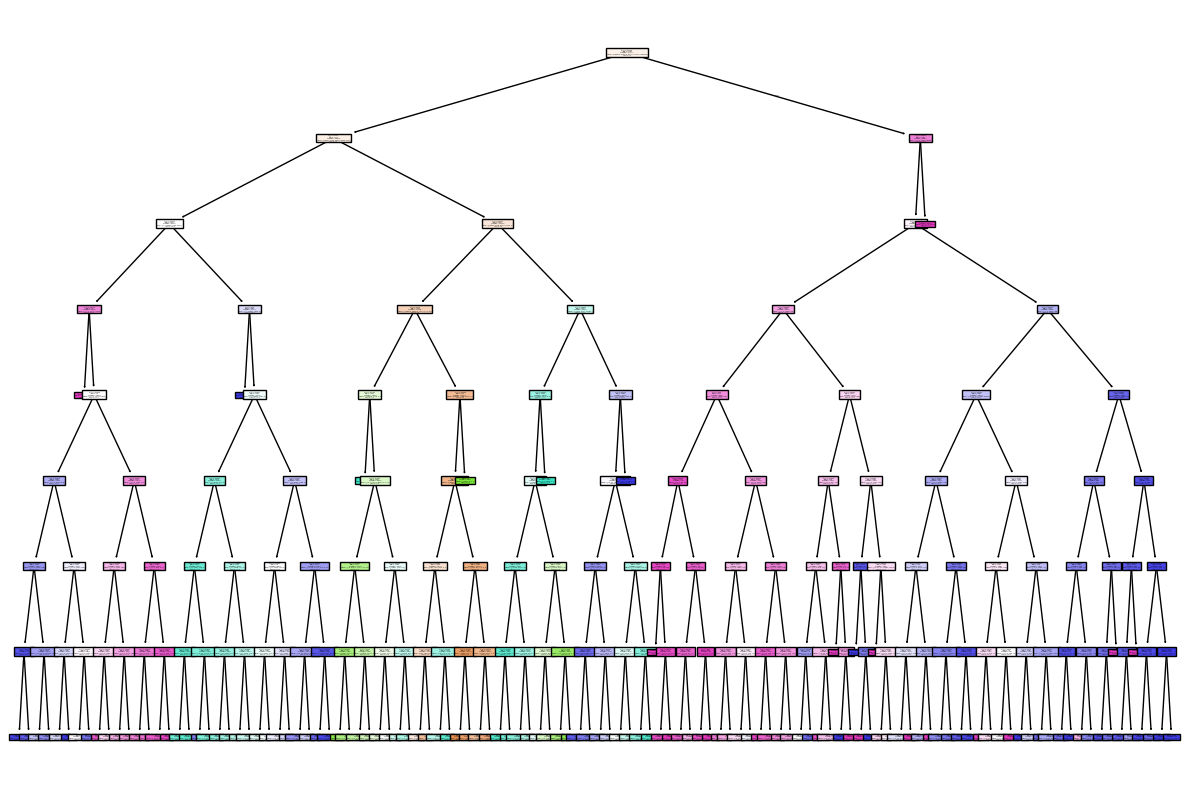

In [3]:
# 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#GridSearch with 5-fold cross-validation for max_depth
param_grid = {"max_depth": [2, 3, 4, 5, 6, 7, 8]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# The best model found in validation
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Optimum max_depth: {grid_search.best_params_['max_depth']}")
# Testing
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='micro')
print(f"Accuracy = (correct predictions)/(all predictions): {test_accuracy:.2f}")
print(f"Test F1 = : {f1:.2f}")
plt.figure(figsize=(15,10))
plot_tree(best_model, filled=True, class_names=[str(cls) for cls in best_model.classes_])
plt.savefig("Pics/DT.svg", format="svg")
plt.show()
# Classification Report
report_dt = classification_report(y_test, y_test_pred, output_dict=True)

In order to show the results of the Desicion Tree, a confusion matrix is shown. This shall highlight the dispersion of results of the desicion tree.

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = best_model.classes_

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Classes')
plt.ylabel('Real Classes')
plt.title('Confusion Matrix Desicion Tree')
plt.savefig("Pics/Confusion_DT.svg", format="svg")
plt.show()

ValueError: continuous is not supported

It can be obtained from the Confusion Matrix, that the desicion tree works best when the actual weight is 0. Thus it was of interest, where this is coming from. The overall input data thus was looked at again, interested in which of the weight values the model was trained with most: 

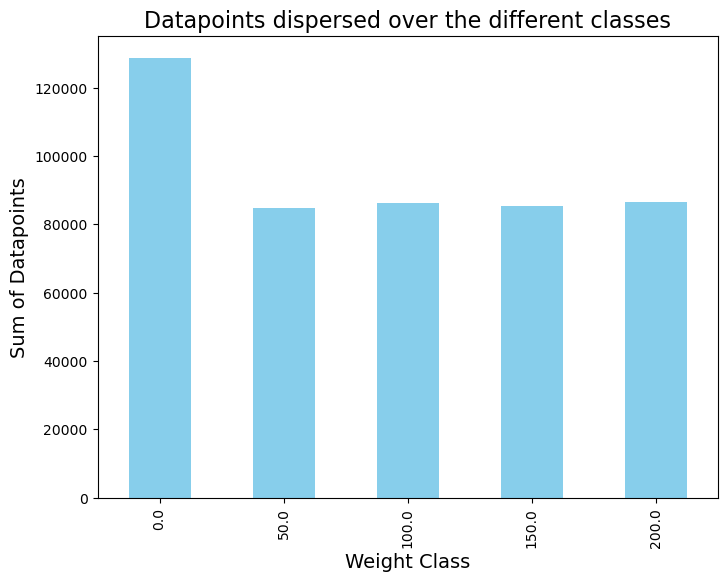

In [5]:
value_counts = pd.Series(y.flatten()).value_counts().sort_index() 

plt.figure(figsize=(8,6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Datapoints dispersed over the different classes for training the Desicion Tree', fontsize=16)
plt.xlabel('Weight Class', fontsize=14)
plt.ylabel('Sum of Datapoints', fontsize=14)
plt.savefig("Pics/Datapoints_weight_bar.svg", format="svg")
plt.show()

## MLP Classifier <a id="Neural-Network"></a>

In [6]:
X = np.loadtxt('db_class_fft_2.csv', delimiter=',')[:, 2].reshape(-1, 1)  #2: US Sensor horizontal
y = np.loadtxt('db_class_fft_2.csv', delimiter=',')[:, 1].reshape(-1, 1) #1: Force imposed
print('Length of Dataset: ', len(X))

Length of Dataset:  471547


In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

#2D to 1D array
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # using the same transformer

# GridSearch with 3-fold cross-validation MLPClassifier
param_grid = {
    "hidden_layer_sizes": [(8,)], #"hidden_layer_sizes": [(2,), (5,), (10,), (20,), (30,), (40,)],
    "activation": ['tanh'],  #"activation": ['relu', 'tanh', 'logistic'],  
    "solver": ['sgd'],  #'adam']
    "learning_rate": ['adaptive'], #only with sgd solver
    "max_iter": [2000]  
}
grid_search = GridSearchCV(MLPClassifier(learning_rate_init=0.01, random_state=42), param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

# calling the best model
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Best hyperparameters: {grid_search.best_params_}")

# Accuracy of the best model
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='micro')
print(f"Test Accuracy = (correct predictions)/(all predictions): {test_accuracy:.2f}")
print(f"Test F1 = : {f1:.2f}")
# Classification Report
report_mlp = classification_report(y_test, y_test_pred, output_dict=True)

Best validation accuracy: 0.57
Best hyperparameters: {'activation': 'tanh', 'hidden_layer_sizes': (8,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}
Test Accuracy = (correct predictions)/(all predictions): 0.61
Test F1 = : 0.61


## Comparison of the Classifiers' Classification Reports <a id="Compare"></a>

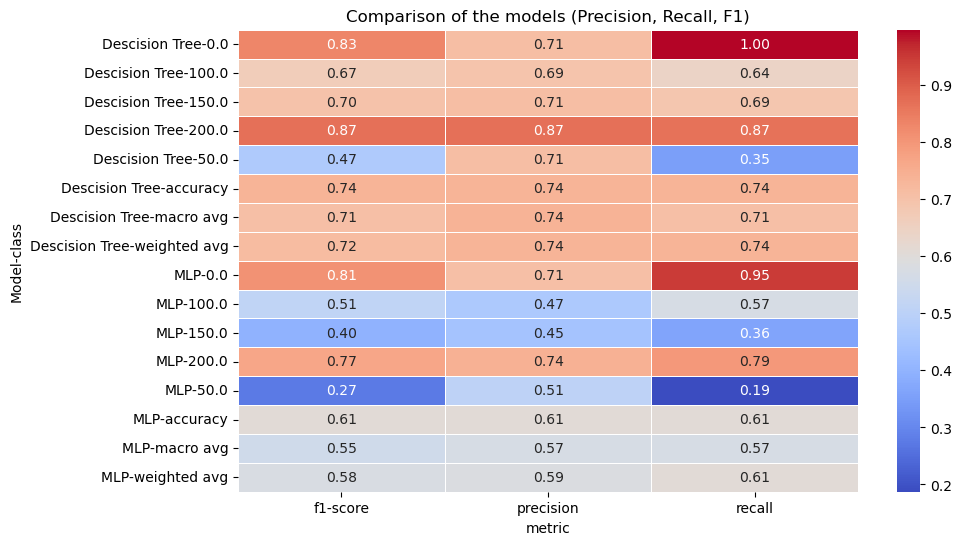

In [8]:
df1 = pd.DataFrame(report_dt).T
df2 = pd.DataFrame(report_mlp).T

# Modellnamen hinzufügen
df1["Model"] = "Descision Tree"
df2["Model"] = "MLP"

df = pd.concat([df1, df2])
df = df.reset_index().rename(columns={"index": "class"})
# Support separieren
df_support = df.pivot(index="Model", columns="class", values="support")
df_metrics = df.drop(columns=["support"]).melt(id_vars=["Model", "class"], var_name="metric", value_name="value")
df_pivot = df_metrics.pivot(index=["Model", "class"], columns="metric", values="value")

# Plotten
plt.figure(figsize=(10, 6))

sns.heatmap(df_pivot, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Comparison of the models (Precision, Recall, F1)")
plt.savefig("Pics/Comparison_weight_models.svg", format="svg")
plt.show()

## SVC Regressor <a id="SVC"></a>

In [9]:
X = np.loadtxt('db_reg_fft_2.csv', delimiter=',')[:, 2].reshape(-1, 1)  #2: US Sensor horizontal
y = np.loadtxt('db_reg_fft_2.csv', delimiter=',')[:, 1].reshape(-1, 1) #1: Force imposed

print('Length of Dataset: ', len(X))

Length of Dataset:  471547


In [10]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
#2D to 1D array
y = y.ravel()

# Reduced Training set for quicker optimisation!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.97, random_state=42)
print('Length of Training Set: ', len(X_train))
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearch with 5-fold cross-validation
param_grid = {
    'C': [500], #[0.1, 1, 2, 10, 20]
    'kernel': ['rbf'], #['linear', 'rbf']
    'epsilon': [0.001], # [0.01, 0.1, 0.3]
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1) #n_jobs, n_iter for quicker optimising
grid_search.fit(X_train_scaled, y_train)

# calling the best model
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Best hyperparameters: {grid_search.best_params_}")

# Accuracy of the best model
y_test_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_test_pred)
print(f"R²-Score of the test data: {r2:.2f}")

Length of Training Set:  14146
Best validation accuracy: 0.85
Best hyperparameters: {'C': 500, 'epsilon': 0.001, 'kernel': 'rbf'}
R²-Score of the test data: 0.85
